# preliminars

## Imports

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.utils import save_image, make_grid
from torchvision.datasets import ImageFolder 
from torch.utils.data import Dataset,DataLoader
import cv2
from PIL import Image, ImageOps, ImageEnhance
from tqdm.notebook import tqdm
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import models
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d


## directories

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directory Francesco
checkpoints_directory='/content/gdrive/MyDrive/Francesco/visiope/checkpoints/WGan2'
generated_images_directory='/content/gdrive/MyDrive/Francesco/visiope/generated_images/Wgan2'
complete_checkpoints_directory='/content/gdrive/MyDrive/Francesco/visiope/complete_checkpoints/Wgan2'


In [ ]:
if not os.path.exists(checkpoints_directory):
   os.makedirs(checkpoints_directory)

if not os.path.exists(generated_images_directory):
   os.makedirs(generated_images_directory)

if not os.path.exists(complete_checkpoints_directory):
   os.makedirs(complete_checkpoints_directory)


## Hyper-parameters

In [ ]:
img_size=64
# size of image height
img_height = 64
# size of image width
img_width = 64

# size of the batches
batch_size = 64

# epoch to start training from
start_index = 1

# number of epochs of training
epochs = 10

# random noise
noise_size=100


# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#fixed noise
torch.manual_seed(100)
fixed_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)

transform=tt.Compose([tt.Resize((img_height,img_width)), 
                      #tt.CenterCrop((img_height,img_width)),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ])



#Dataset

In [ ]:
def augmentation(image):
   
    # hange saturation randomly
    add_remove_saturation = random.uniform(-0.2,0.2)
    editor = ImageEnhance.Color(image)
    image = editor.enhance(1+add_remove_saturation)

    # random sharpness adjustment
    add_remove_sharpness = random.uniform(-0.2,0.2)
    editor = ImageEnhance.Sharpness(image)
    image = editor.enhance(1+add_remove_sharpness)
    
    mirror = random.randint(0,1)
    if mirror==1:
        image = ImageOps.mirror(image)
    
    return image

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, root_directory, transform, augment):
        self.root_directory = root_directory
        self.transform = transform
        self.augment=augment
        self.all_images = os.listdir(root_directory)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, index):
        img=self.all_images[index]
        img_path = os.path.join(self.root_directory,img)
        image = Image.open(img_path).convert('RGB') 
        transformed_image = self.transform(image)
        if self.augment:
           image = augmentation(image)
        image = self.transform(image)
        return image



## auxiliary fuctions

In [ ]:
from matplotlib.widgets import Slider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from PIL import Image


def build_slider(img_dir,title):
  images = []

  def show_image(epoch):
    
    fig=plt.imshow(images[epoch])
    plt.title(title)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

  for filename in os.listdir(img_dir):
        img = Image.open(os.path.join(img_dir, filename))
        
        images.append(img) 
  %matplotlib inline
  interact(show_image, epoch=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0))

In [ ]:
# To show images of dataset
def show_images(dataset):
  output_image = (make_grid(dataset, nrow=8).permute(1, 2, 0).detach().numpy())
  output_image = output_image * 0.5 + 0.5
  output_image = output_image * 255.0
  output_image = output_image.astype(int)

  fig = plt.figure(figsize=(8, 8), facecolor="w")
  plt.imshow(output_image)
  plt.axis("off")
  plt.show()


## Dataloader

In [ ]:
dataset_directory='/content/gdrive/MyDrive/VISIOPE/datasets/resized150/resized150'

In [ ]:
dataset = CustomDataSet(dataset_directory, transform, augment=False)

In [ ]:
len(dataset)

10624

In [ ]:
dataloader = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
images = next(iter(dataloader))

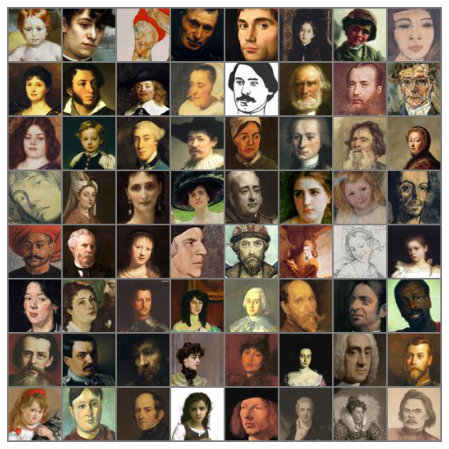

In [ ]:
show_images(images)

#Wgan model

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__()

        self.discriminator=nn.Sequential(
            nn.Conv2d(3, d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d, d*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d*2,affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d*2, d*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d*4,affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d*4, d*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(d*8,affine=True),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d*8, 1, kernel_size=4, stride=1, padding=0),
        )

    def forward(self,x):
        return self.discriminator(x)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self,d=64):
        super(Generator, self).__init__()


        self.generator=nn.Sequential(
            nn.ConvTranspose2d(noise_size, d*8, 4, 1, 0),
            nn.BatchNorm2d(d*8),
            nn.ReLU(),

            nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.ReLU(),

            nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.ReLU(),

            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.BatchNorm2d(d),
            nn.ReLU(),

            nn.ConvTranspose2d(d, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

## initialize

In [ ]:
# Initialize generator and discriminator

generator = Generator()
critic = Discriminator()

generator=generator.to(device)
critic = critic.to(device)


## initialize weights

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Initialize weights
generator.apply(weights_init_normal)    
critic.apply(weights_init_normal)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

## load checkpoints

In [ ]:
# Load pretrained models
start_index=199
critic.load_state_dict(torch.load(f"{checkpoints_directory}/D_{start_index}.pth"))
generator.load_state_dict(torch.load(f"{checkpoints_directory}/G_{start_index}.pth"))


<All keys matched successfully>

# Train

## Training Parameters

In [ ]:
# Optimizers
lr_wc=5e-5
weight_clip=0.01
critic_iterations=5
optimizer_C = optim.RMSprop(critic.parameters(), lr_wc)  
optimizer_G = optim.RMSprop(generator.parameters(), lr_wc) 

def wasserstein_loss(label):
  return torch.mean(label)




##fid score



fid score is a metric that evaluates the difference between the features extracted by  a batch of real images and fake images generated by our model, the features are encoded and then re-decoded in an array of 2048 elements, that is considered as a multivariate distribution.

the parameters of the distribution is computed and then computed the FID SCORE ${d^2 = ||\mu_1 – \mu_2||^2 + Tr\biggl[C_1 + C_2 – 2\sqrt{C_1*C_2}\biggl]}$



the implementation, that is an adaptation of the official one  is taken from https://github.com/mseitzer/pytorch-fid

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception = InceptionV3([block_idx])
inception = inception.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
def calculate_activation_statistics(images,model,batch_size=64, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def compute_fid(images_real,images_fake):
     mu_1,std_1=calculate_activation_statistics(images_real,inception,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,inception,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

##Train Wgan

In [ ]:
def model_fit(data, epochs, start_idx):
  
  if(start_idx==1):

    arr_losses_generator = []
    arr_losses_discriminator = []
    arr_scores_real_imgs = []
    arr_scores_fake_imgs= []
    arr_fid_scores=[]

  else:
    checkpoint = torch.load(f"{complete_checkpoints_directory}/Checkpoint{start_idx-1}.tar")
    generator.load_state_dict(checkpoint['generator_checkpoints'])
    critic.load_state_dict(checkpoint['discriminator_checkpoints'])
    optimizer_G.load_state_dict(checkpoint['generator_optimizer'])
    optimizer_C.load_state_dict(checkpoint['discriminator_optimizer'])
    arr_losses_generator = checkpoint['generator_losses']
    arr_losses_discriminator = checkpoint['discriminator_losses']
    arr_fid_scores=checkpoint['fid_score']

  generator.train()
  critic.train()


  for epoch in range(epochs):

    losses_generator = 0.0
    losses_discriminator = 0.0
    fid_scores=[]
    
    tqdm_bar = tqdm(data, desc=f'Training Epoch {epoch+start_idx} ', total=int(len(data)))
    for index, real_images in enumerate(tqdm_bar):
      real_images = real_images.to(device)
    
      # training the discriminator
      
      for _ in range(critic_iterations):
        optimizer_C.zero_grad()
        random_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
        real_predictions=critic(real_images).squeeze()                              
        fake_predictions = critic(generator(random_noise).detach()).squeeze() 
  
        critic_loss =  -(wasserstein_loss(real_predictions)-wasserstein_loss(fake_predictions)) 
        critic.zero_grad()
        critic_loss.backward()
        optimizer_C.step()


        for par in critic.parameters():
                par.data.clamp_(-weight_clip, weight_clip)

      # train generator                                                          
      random_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
      # optimizer_G.zero_grad()
      fake_imgs = generator(random_noise)

      #compute the loss
      generator_predictions = critic(fake_imgs).squeeze()                 
      generator_loss=-wasserstein_loss(generator_predictions)
      
      # Update generator weights
      generator.zero_grad()
      generator_loss.backward()
      optimizer_G.step()

      losses_generator +=generator_loss.item()
      losses_discriminator+=critic_loss.item()
      fid_scores.append(compute_fid(fake_imgs, real_images))
      tqdm_bar.set_postfix(Gen_loss=losses_generator/(index+1), Disc_loss=losses_discriminator/(index+1))

      
    arr_losses_generator.append(generator_loss.item())
    arr_losses_discriminator.append(critic_loss.item())
    arr_fid_scores.append(np.mean(fid_scores))

    with torch.no_grad():
      fake_images = generator(fixed_noise)
                         
    image_name = 'generated-images-{0:0=4d}.png'.format(epoch+start_idx+1)
    save_image(fake_images, os.path.join(generated_images_directory, image_name), normalize=True, nrow=8)

    torch.save({
            'generator_checkpoints': generator.state_dict(),
            'discriminator_checkpoints': critic.state_dict(),
            'discriminator_optimizer':  optimizer_C.state_dict(),
            'generator_optimizer': optimizer_G.state_dict(),
            'fid_score': arr_fid_scores,
            'last_fid': np.mean(fid_scores),
            'generator_losses': arr_losses_generator,
            'discriminator_losses': arr_losses_discriminator,
            'scores_on_real_imgs': arr_scores_real_imgs,
            'scores_on_fake_imgs':arr_scores_fake_imgs,
            'epoch': epoch+start_index
            },f"{complete_checkpoints_directory}/Checkpoint{epoch+start_idx}.tar" )
    

  return np.mean(fid_scores),arr_fid_scores, arr_losses_generator, arr_losses_discriminator



In [ ]:
run = model_fit(dataloader, epochs, start_index)

## training improved Wgan(gradient penalty)





























































































































In [ ]:
lr_gp=1e-4
optimizer_C = torch.optim.Adam(critic.parameters(), lr=lr_gp, betas=(0.0, 0.9))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_gp, betas=(0.0, 0.9))

critic_iterations=5
g_lambda=10


def wasserstein_loss(label):
  return torch.mean(label)

In [ ]:
def gradient_penalty(critic, real, fake, device="cuda"):
    batch, channels, height, weight = real.shape
    alpha = torch.rand((batch, 1, 1, 1)).repeat(1, channels, height, weight).to(device)
    interpolated = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    scores = critic(interpolated)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    g_norm = gradient.norm(2, dim=1)
    gp = torch.mean((g_norm - 1) ** 2)
    return gp


In [ ]:
def model_fit(data, epochs, start_idx):
  
  if(start_idx==1):

    arr_losses_generator = []
    arr_losses_discriminator = []
    arr_scores_real_imgs = []
    arr_scores_fake_imgs= []
    arr_fid_scores=[]

  else:
    checkpoint = torch.load(f"{complete_checkpoints_directory}/Checkpoint{start_idx-1}.tar")
    generator.load_state_dict(checkpoint['generator_checkpoints'])
    critic.load_state_dict(checkpoint['discriminator_checkpoints'])
    optimizer_G.load_state_dict(checkpoint['generator_optimizer'])
    optimizer_C.load_state_dict(checkpoint['discriminator_optimizer'])
    arr_losses_generator = checkpoint['generator_losses']
    arr_losses_discriminator = checkpoint['discriminator_losses']
    arr_fid_scores=checkpoint['fid_score']

  generator.train()
  critic.train()

  for epoch in range(epochs):
    losses_generator = 0.0
    losses_discriminator = 0.0
    fid_scores=[]
    tqdm_bar = tqdm(data, desc=f'Training Epoch {epoch+start_index} ', total=int(len(data)))
    
    for index, real_images in enumerate(tqdm_bar):
        real_images = real_images.to(device)

        for _ in range(critic_iterations):
            
            random_noise = torch.randn(batch_size, noise_size, 1, 1, device=device)

            fake_imgs = generator(random_noise)

            real_predictions=critic(real_images).squeeze()                              
            fake_predictions = critic(generator(random_noise).detach()).squeeze() 
  
            gp = gradient_penalty(critic, real_images, fake_imgs, device=device)

            loss_real=wasserstein_loss(real_predictions)

            loss_fake=wasserstein_loss(fake_predictions)

            critic_loss = (-(loss_real - loss_fake) + g_lambda * gp)
            
            critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            optimizer_C.step()

        # Train Generator:
        
        fake = critic(fake_imgs.detach())
        generator_loss = -wasserstein_loss(fake)
        generator.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

  
        losses_generator +=generator_loss.item()
        losses_discriminator+=critic_loss.item()
        fid_scores.append(compute_fid(fake_imgs, real_images))
        tqdm_bar.set_postfix(Gen_loss=losses_generator/(index+1), Disc_loss=losses_discriminator/(index+1))

      
    arr_losses_generator.append(generator_loss.item())
    arr_losses_discriminator.append(critic_loss.item())
    arr_fid_scores.append(np.mean(fid_scores))

    with torch.no_grad():
      fake_images = generator(fixed_noise)
                         
    image_name = 'generated-images-{0:0=4d}.png'.format(epoch+start_idx+1)
    save_image(fake_images, os.path.join(generated_images_directory, image_name), normalize=True, nrow=8)

    torch.save({
            'generator_checkpoints': generator.state_dict(),
            'discriminator_checkpoints': critic.state_dict(),
            'discriminator_optimizer':  optimizer_C.state_dict(),
            'generator_optimizer': optimizer_G.state_dict(),
            'fid_score': arr_fid_scores,
            'last_fid': np.mean(fid_scores),
            'generator_losses': arr_losses_generator,
            'discriminator_losses': arr_losses_discriminator,
            'scores_on_real_imgs': arr_scores_real_imgs,
            'scores_on_fake_imgs':arr_scores_fake_imgs,
            'epoch': epoch+start_index
            },f"{complete_checkpoints_directory}/Checkpoint{epoch+start_idx}.tar" )
    

  return np.mean(fid_scores),arr_fid_scores, arr_losses_generator, arr_losses_discriminator
            

In [ ]:
run = model_fit(dataloader, epochs, start_index)

# Evaluation of the results

## evaluation of the Wgan

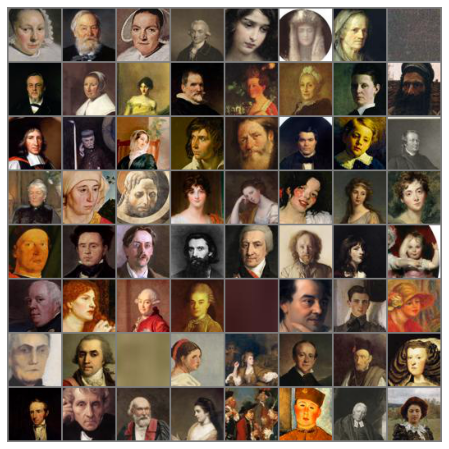

In [ ]:
show_images(images)

In [ ]:
WganDir='/content/gdrive/MyDrive/VISIOPE/FinalProject/Wgan_WeightClipping/generated_images'

In [ ]:
build_slider(WganDir,"Portraits with Wgan")

interactive(children=(IntSlider(value=0, description='epoch', max=249), Output()), _dom_classes=('widget-inter…

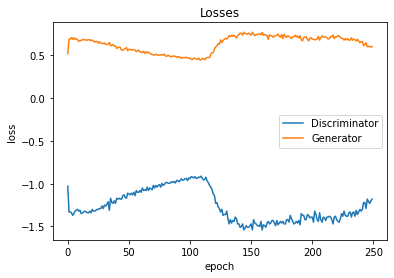

In [ ]:
plt.plot(arr_losses_discriminator, '-')
plt.plot(arr_losses_generator, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

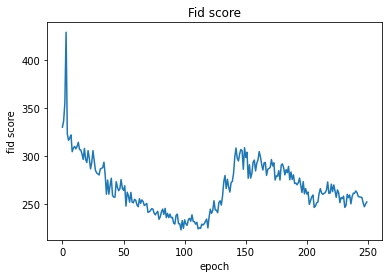

In [ ]:
plt.plot(arr_fid_scores, '-')
plt.xlabel('epoch')
plt.ylabel('fid score')
plt.title('Fid score');

In [ ]:
np.argmin(arr_fid_scores)

97

In [ ]:
min(arr_fid_scores)

222.81119310260732

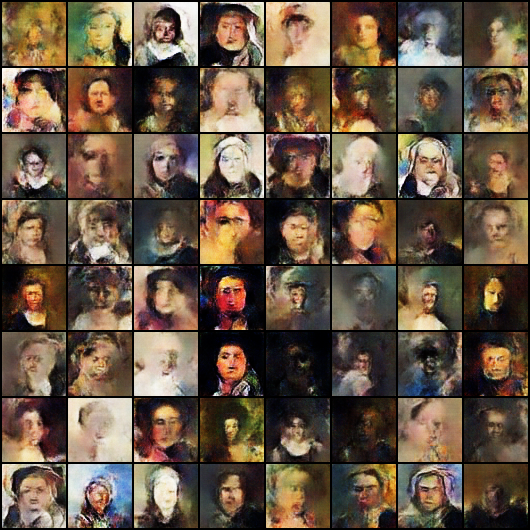

In [ ]:
Image.open(os.path.join(WganDir,'generated-images-{0:0=4d}.png'.format(np.argmin(arr_fid_scores)+1)))


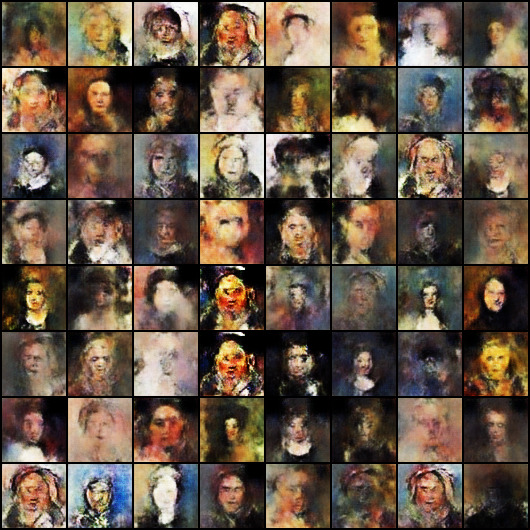

In [ ]:
Image.open(os.path.join(WganDir,'generated-images-{0:0=4d}.png'.format(250)))

## evaluation of Wgan 2

In [ ]:
weight_clipping_Wgan_directory='/content/gdrive/MyDrive/VISIOPE/FinalProject/Wgan_weight_clipping/generated_images'
complete_checkpoints_directory='/content/gdrive/MyDrive/VISIOPE/FinalProject/Wgan_weight_clipping/total_checkpoints'

In [ ]:
checkpoint = torch.load(f"{complete_checkpoints_directory}/Checkpoint{277}.tar")
arr_losses_generator = checkpoint['generator_losses']
arr_losses_discriminator = checkpoint['discriminator_losses']
arr_fid_scores=checkpoint['fid_score']

In [ ]:
build_slider(weight_clipping_Wgan_directory,"Portraits with Wgan")

interactive(children=(IntSlider(value=0, description='epoch', max=276), Output()), _dom_classes=('widget-inter…

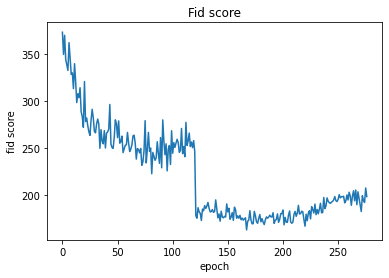

In [ ]:
plt.plot(arr_fid_scores, '-')
plt.xlabel('epoch')
plt.ylabel('fid score')
plt.title('Fid score');

In [ ]:
min(arr_fid_scores)

163.3692114474957

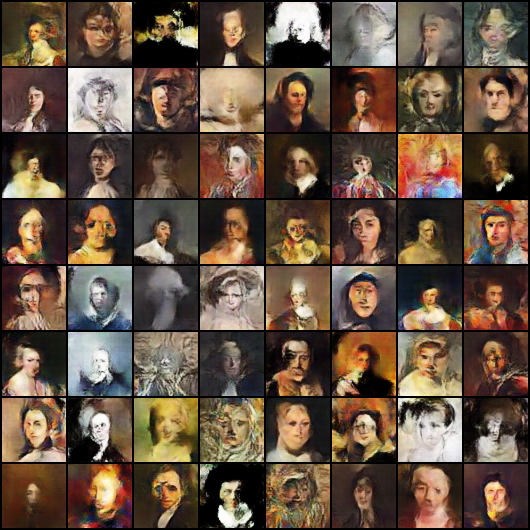

In [ ]:
Image.open(os.path.join(weight_clipping_Wgan_directory,'generated-images-{0:0=4d}.png'.format(np.argmin(arr_fid_scores)+1)))

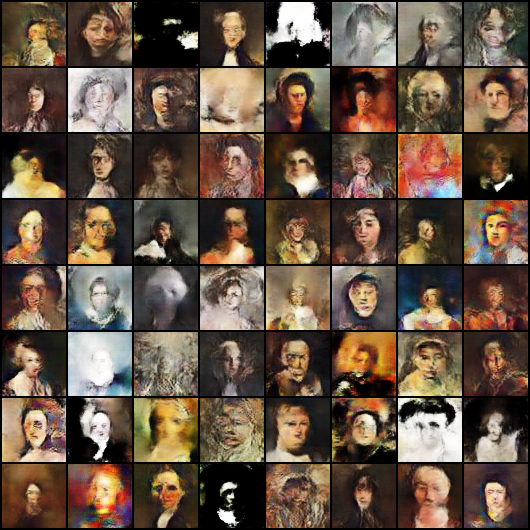

In [ ]:
Image.open(os.path.join(weight_clipping_Wgan_directory,'generated-images-{0:0=4d}.png'.format(277)))

## evaluation of the improved Wgan1

In [ ]:
improvedWgan1Dir = generated_images_directory
build_slider(improvedWgan1Dir,"Portraits with Wgan")

interactive(children=(IntSlider(value=0, description='epoch', max=371), Output()), _dom_classes=('widget-inter…

In [ ]:
arr_fid_scores[304]

178.4711728612893

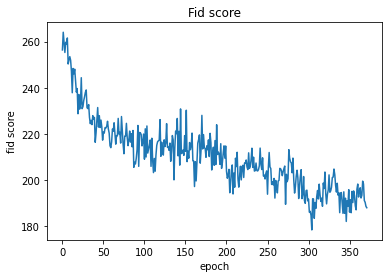

In [ ]:
plt.plot(arr_fid_scores, '-')
plt.xlabel('epoch')
plt.ylabel('fid score')
plt.title('Fid score');

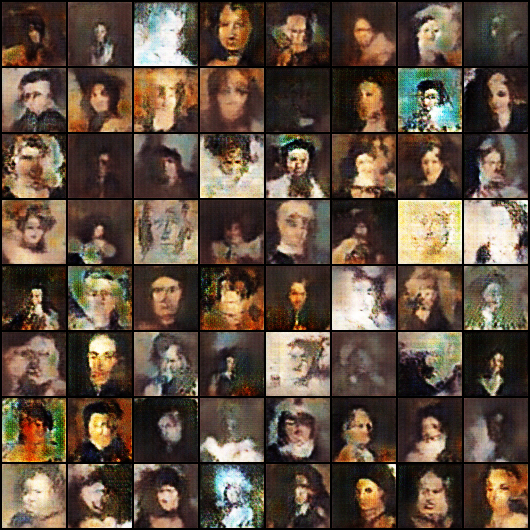

In [ ]:
Image.open(os.path.join(improvedWgan1Dir,'generated-images-{0:0=4d}.png'.format(np.argmin(arr_fid_scores)+1)))

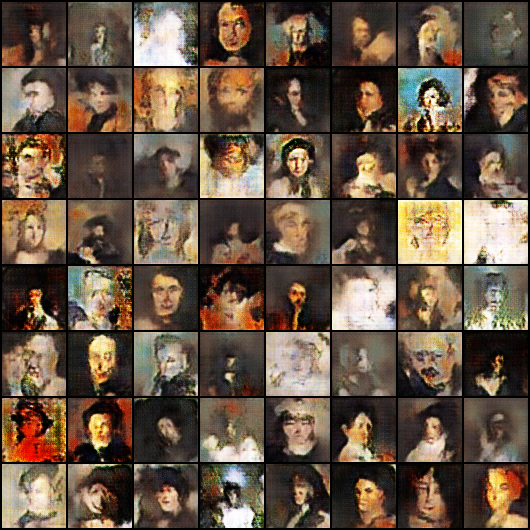

In [ ]:
Image.open(os.path.join(improvedWgan1Dir,'generated-images-{0:0=4d}.png'.format(372)))

##evaluation of the improved Wgan 2

In [ ]:
improvedWgan2Dir ='/content/gdrive/MyDrive/VISIOPE/FinalProject/improvedWgan2/generated_images'
build_slider(improvedWgan2Dir,"Portraits with Wgan")

interactive(children=(IntSlider(value=0, description='epoch', max=285), Output()), _dom_classes=('widget-inter…

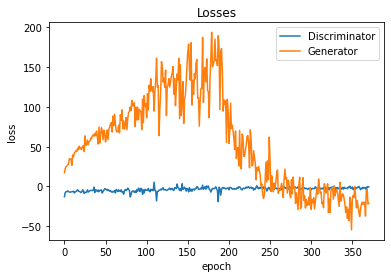

In [ ]:
plt.plot(arr_losses_discriminator, '-')
plt.plot(arr_losses_generator, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
np.argmin(arr_fid_scores)

271

In [ ]:
min(arr_fid_scores)

173.56677067853235

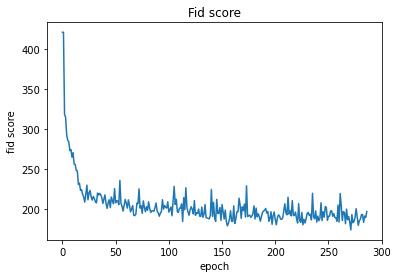

In [ ]:
plt.plot(arr_fid_scores, '-')
plt.xlabel('epoch')
plt.ylabel('fid score')
plt.title('Fid score');

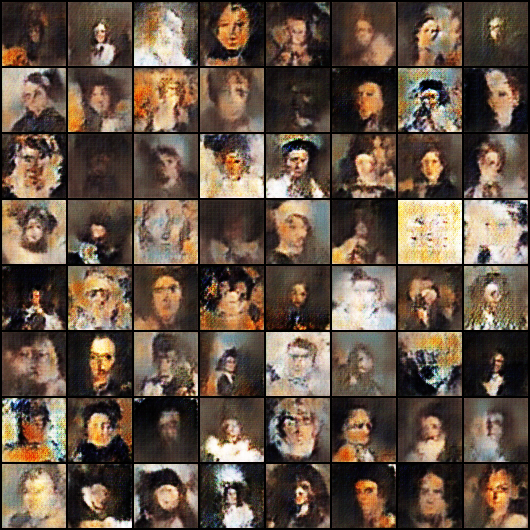

In [ ]:
Image.open(os.path.join(improvedWgan1Dir,'generated-images-{0:0=4d}.png'.format(np.argmin(arr_fid_scores)+1)))

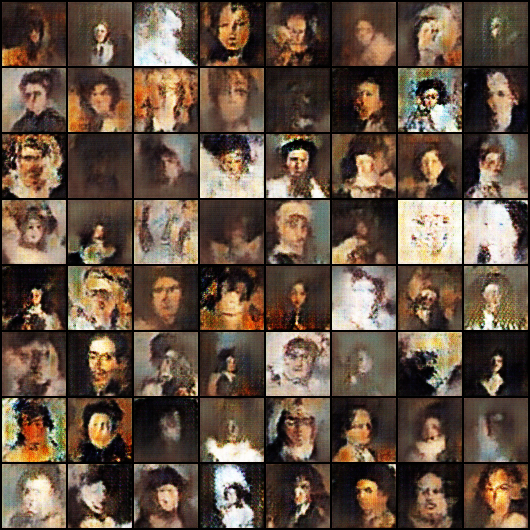

In [ ]:
Image.open(os.path.join(improvedWgan1Dir,'generated-images-{0:0=4d}.png'.format(287)))